In [1]:
import os
import numpy as np
import pandas as pd
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sys import platform
import inspect
import arviz as az

az.style.use('arviz-darkgrid')
az.rcParams['plot.max_subplots'] = 50

## 1. Open / combine datasets

In [2]:
file = "nerd_shit1.csv"
data = pd.read_csv(file)
data["deter"] = 1

file2 = "TravisRollsDataset.csv"
data2 = pd.read_csv(file2)
data2["deter"] = 0

# merge the datasets
total_data_rodeo = pd.concat([data2, data], axis=0).reset_index()

# shuffle the data 3x in replicable way
col_names = list(data.columns)
rodeo = total_data_rodeo.sample(frac=1, random_state=1234567).reset_index(drop=True)
rodeo = rodeo.sample(frac=1, random_state=57389).reset_index(drop=True)
rodeo = rodeo.sample(frac=1, random_state=98754).reset_index(drop=True)
rodeo = rodeo[col_names]

rodeo.head()

,id,roll,adv,stat,basis,type,deter
0,834.0,12,advantage,DEX,ranged,attack,1
1,1948.0,10,disadvantage,INIT,dexterity,save,1
2,1343.0,19,advantage,INT,investigate,check,1
3,1592.0,11,advantage,ATTACK,initiative,NaN,1
4,1090.0,18,advantage,CHA,initiative,NaN,1


## 2. Feature Engineering

In [25]:
data_dums = pd.get_dummies(rodeo)

# add back roll column
data_dums["roll"] = total_data_rodeo.roll
data_dums["basis_type"] = total_data_rodeo["basis"].astype(str) + "_" + total_data_rodeo["type"].astype(str)

# create bins for the rolls
data_dums["rollbins"] = pd.cut(data_dums.roll, bins=[0, 12, 20], labels=[0,1])
data_dums["deter"] = total_data_rodeo.deter

rodeo_dums2 = data_dums[["adv_advantage", "adv_disadvantage", "stat_ATTACK"]]

data_dums_ADVI = data_dums[["deter", "rollbins", "roll", "adv_advantage", "adv_disadvantage", "stat_ATTACK"]]
data_dums_ADVI_trav = data_dums.query("deter == 0")
data_dums_ADVI_rand = data_dums.query("deter == 1")

## 3. Attempted Hierarchical Model for each Dummy Column

This was a complete disaster and shut down my computer multiple times. Thus I have commented it out to avoid destroying further work. 

In [4]:
## https://docs.pymc.io/notebooks/GLM-linear.html

import pymc3 as pm
from pymc3 import  *

#copy the x and y values into new variables
ycol = total_data_rodeo.deter.copy()
#don't include die outcome column
xcols = data_dums.copy() 

#collect count values
xcolumns = list(xcols.columns)
coeff_count = len(xcolumns)
die_side_count = data_dums.rollbins.nunique()

In [7]:
# with pm.Model() as hierarchical_model:

#     # Priors for the model parameters
#     # Gaussians for the means of the priors of the random intercepts and slopes
#     mus = []
#     for i in range(coeff_count):
#         mus.append(pm.Normal("mu_"+str(i), mu=0., sd=1e5))
    
#     # Half-Cauchy for the standard deviations of the priors 
#     # of the random intercepts and slopes
#     sigmas = []
#     for i in range(coeff_count):
#         sigmas.append(pm.HalfCauchy("sigma_"+str(i), 1e5))

#     # Gaussian priors for random intercepts and slopes
#     priors = []
#     for i in range(coeff_count):
#         priors.append(pm.Normal("prior_"+str(i), mu=mus[i], 
#                             sd=sigmas[i], shape=die_side_count))
    
#     # Linear model, initialize w intercept
#     mu = priors[0][rollbins] 
    
#     for die in range(1,coeff_count):
#         mu += priors[die][rollbins] * xcols.iloc[:, die]
    
#     # Transform outcome to probability
#     theta = pm.Deterministic('theta', pm.invlogit(mu))
#     y_hat = pm.Bernoulli('y_hat', p=theta, observed=ycol)
    
#     # Sample the posterior
#     hierarchical_trace = pm.sample(draws=500, #1000
#                             step=pm.NUTS(target_accept=0.99), 
#                             tune=2000) #5000

In [8]:
# # Trace plots
# with hierarchical_model:
#     az.plot_trace(hierarchical_trace)

In [9]:
# # Results in table
# with hierarchical_model:
#     main_idata = az.from_pymc3(hierarchical_trace)
    
# azsum_df = az.summary(main_idata, round_to=2)
# azsum_df.sort_values(by=["r_hat"])

In [10]:
# # Forest plots
# plt.figure(figsize=(6,14))
# with hierarchical_model:
#     pm.forestplot(hierarchical_trace);

## 4. Logistic GLM from selected features, first Travis, then Simulations

In [5]:
rodeo_mult = rodeo.iloc[:, 1:].copy() #no ID

def assess_important(x):
    if x['adv']=="disadvantage" or x['basis'] in ["melee", "ranged", "dexterity", "strength"]:
        return 1
    else:
        return 0
rodeo_mult['important'] = rodeo_mult.apply(assess_important, axis=1)
rodeo_mult["rollbins"] = pd.cut(rodeo_mult.roll, bins=[0, 12, 20], labels=[0,1])

txt_to_num = ["adv", "stat", "basis", "type"]

for c in txt_to_num:
    vallist = list(rodeo_mult[c].unique())
    tmpdict = dict(zip(vallist, list(range(len(vallist)))))
    rodeo_mult[c] = rodeo_mult[c].replace(tmpdict)

rodeo_mult.head()

,roll,adv,stat,basis,type,deter,important,rollbins
0,12,0,0,0,0,1,1,0
1,10,1,1,1,1,1,1,0
2,19,0,2,2,2,1,0,1
3,11,0,3,3,3,1,0,0
4,18,0,4,3,3,1,0,1


In [6]:
rodeo_mult.rollbins.dtype

CategoricalDtype(categories=[0, 1], ordered=True)

In [15]:
rodeo_mult_trav = rodeo_mult.query("deter == 0")
# logistic estimate of the posterior distribution for TRAVIS DATA
with pm.Model() as trav_log:
        Y = rodeo_mult_trav["rollbins"]
                                # roll + adv + stat + basis + type + important
                                # adv_advantage + adv_disadvantage + stat_ATTACK
        pm.glm.GLM.from_formula('Y ~ adv + stat + basis + type + important',\
                                rodeo_mult_trav, family=pm.glm.families.Binomial())
        advi_fit_trav = pm.fit(50000, method="advi", progressbar=True, random_seed=2031)

Average Loss = 155.2: 100%|██████████| 50000/50000 [00:18<00:00, 2685.48it/s] 
Finished [100%]: Average Loss = 155.19


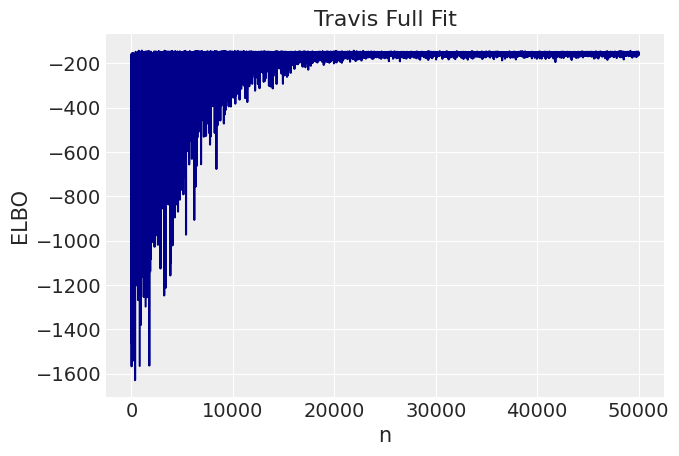

In [16]:
import seaborn as sns

trav_elbo = pd.DataFrame(
    {'ELBO': -advi_fit_trav.hist,
     'n': np.arange(advi_fit_trav.hist.shape[0])})

ax42 = sns.lineplot(y='ELBO', x='n', data=trav_elbo, color="darkblue")
ax42.set_title('Travis Full Fit');

In [18]:
rodeo_mult_gen = rodeo_mult.query("deter == 1")
# # logistic estimate of the posterior distribution for WEIGHTED GENERATED DATA
with pm.Model() as rand_log:
        Y = rodeo_mult_gen["rollbins"]
        pm.glm.GLM.from_formula('Y ~ adv + stat + basis + type + important',\
                                rodeo_mult_gen, family=pm.glm.families.Binomial())
        advi_fit_rand = pm.fit(50000, method="advi", progressbar=True, random_seed=2031)
        
        # WHY IS THE LOSS SO HIGH

Average Loss = 1,169.1: 100%|██████████| 50000/50000 [00:35<00:00, 1417.53it/s]
Finished [100%]: Average Loss = 1,169


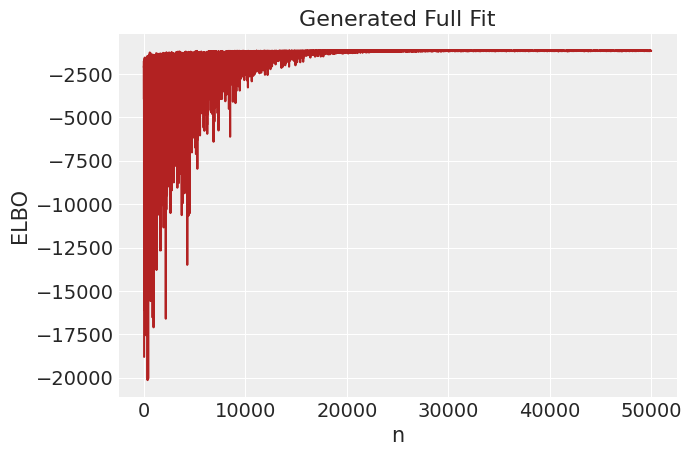

In [19]:
rand_elbo = pd.DataFrame(
    {'ELBO': -advi_fit_rand.hist,
     'n': np.arange(advi_fit_rand.hist.shape[0])})

ax44 = sns.lineplot(y='ELBO', x='n', data=rand_elbo, color="firebrick")
ax44.set_title('Generated Full Fit');

## 5. Plot Posterior Distributions from ADVI

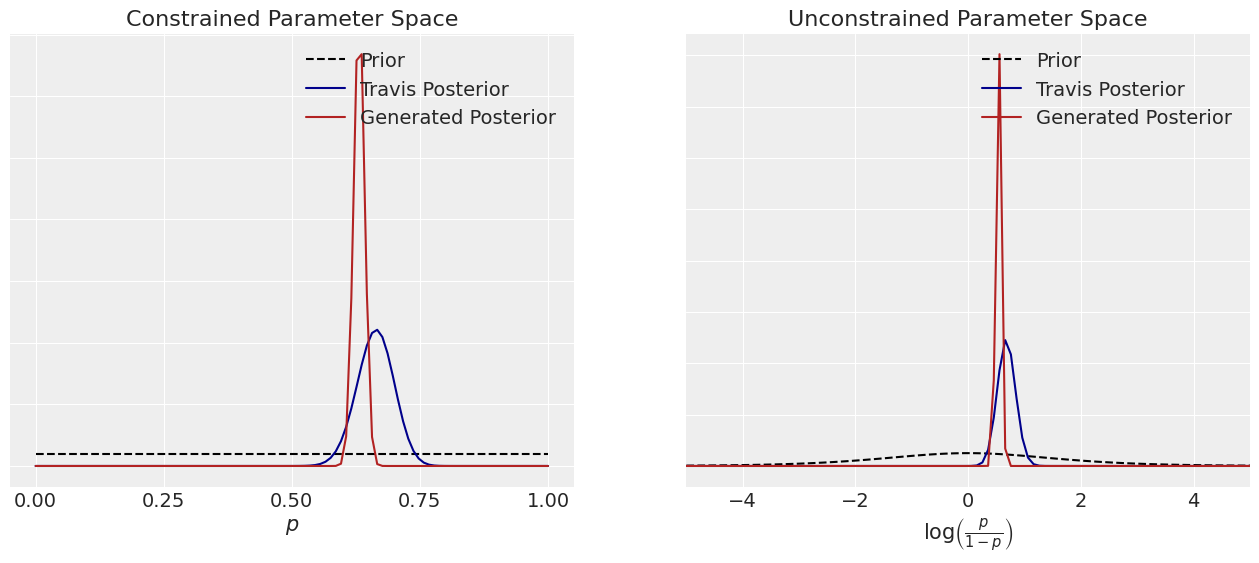

In [20]:
# The approximation parameters
import scipy as sp

advi_gen_mu = advi_fit_trav.mean.eval()
advi_gen_std = advi_fit_trav.std.eval()
advi_gen_dist = sp.stats.norm(advi_gen_mu, advi_gen_std)

# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

trav_bins = rodeo_mult_trav["rollbins"].astype('int32')
bins = rodeo_mult_gen["rollbins"].astype('int32')

prior = sp.stats.uniform(0, 1) #uniform numberline
posterior = sp.stats.beta(1 + trav_bins.sum(),
                          1 + (1 - trav_bins).sum())
posterior_gen = sp.stats.beta(1 + bins.sum(),
                          1 + (1 - bins).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100) #uniform numberline
const_ax.plot(const_x, prior.pdf(const_x),
              '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c='darkblue', label='Travis Posterior');
const_ax.plot(const_x, posterior_gen.pdf(const_x),
              c='firebrick', label='Generated Posterior');
const_ax.set_xticks(np.linspace(0, 1, 5)); #uniform numberline
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100) #uniform numberline
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x),
              '--', c='k', label = "Prior");
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x),
              c='darkblue', label = "Travis Posterior");
trans_ax.plot(trans_x, expit_trans_pdf(posterior_gen.pdf, trans_x),
              c='firebrick', label = "Generated Posterior");

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');
trans_ax.legend(loc=1);

## 6. Logistic GLM from selected features, first Travis, then Simulations

In [21]:
rodeo_mult = rodeo.iloc[:, 1:].copy() #no ID

def assess_important(x):
    if x['adv']=="disadvantage" or x['basis'] in ["melee", "ranged", "dexterity", "strength"]:
        return 1
    else:
        return 0
rodeo_mult['important'] = rodeo_mult.apply(assess_important, axis=1)

txt_to_num = ["adv", "stat", "basis", "type"]

for c in txt_to_num:
    vallist = list(rodeo_mult[c].unique())
    tmpdict = dict(zip(vallist, list(range(len(vallist)))))
    rodeo_mult[c] = rodeo_mult[c].replace(tmpdict)

rodeo_mult.head()

,roll,adv,stat,basis,type,deter,important
0,12,0,0,0,0,1,1
1,10,1,1,1,1,1,1
2,19,0,2,2,2,1,0
3,11,0,3,3,3,1,0
4,18,0,4,3,3,1,0


In [26]:
# logistic estimate of the posterior distribution for TRAVIS DATA
with pm.Model() as trav_log:
        Y = data_dums_ADVI_trav["rollbins"]
                                # roll + adv + stat + basis + type + important
                                # adv_advantage + adv_disadvantage + stat_ATTACK
        pm.glm.GLM.from_formula('Y ~ adv_advantage + adv_disadvantage + stat_ATTACK',\
                                data_dums_ADVI_trav, family=pm.glm.families.Binomial())
        advi_fit_trav = pm.fit(300000, method="advi", progressbar=True, random_seed=2031)

Average Loss = 133.4: 100%|██████████| 300000/300000 [01:50<00:00, 2718.57it/s] 
Finished [100%]: Average Loss = 133.39


Text(0.5, 1.0, 'Travis Reduced Fit')

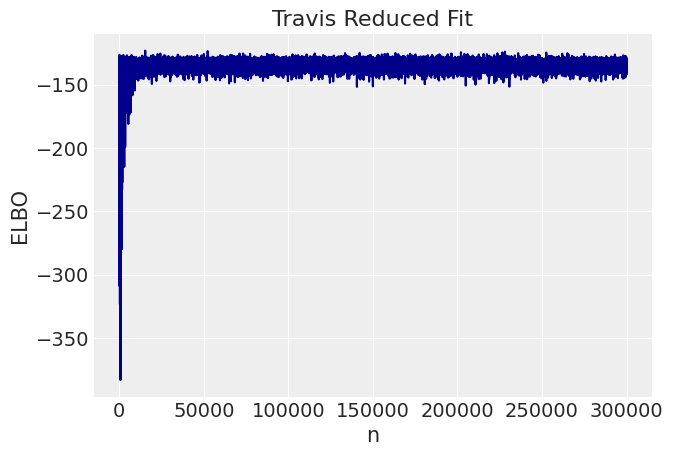

In [27]:
import seaborn as sns

trav_elbo = pd.DataFrame(
    {'ELBO': -advi_fit_trav.hist,
     'n': np.arange(advi_fit_trav.hist.shape[0])})

ax42 = sns.lineplot(y='ELBO', x='n', data=trav_elbo, color="darkblue")
ax42.set_title('Travis Reduced Fit')

In [28]:
# # logistic estimate of the posterior distribution for RANDOM DATA
with pm.Model() as rand_log:
        Y = data_dums_ADVI_rand["rollbins"]
        pm.glm.GLM.from_formula('Y ~ adv_advantage + adv_disadvantage + stat_ATTACK',\
                                data_dums_ADVI_rand, family=pm.glm.families.Binomial())
        advi_fit_rand = pm.fit(300000, method="advi", progressbar=True, random_seed=2031)
        
# DON'T LOVE THAT AVERAGE LOSS

Average Loss = 1,344.1: 100%|██████████| 300000/300000 [04:00<00:00, 1248.30it/s]
Finished [100%]: Average Loss = 1,344.1


Text(0.5, 1.0, 'Generated Reduced Fit')

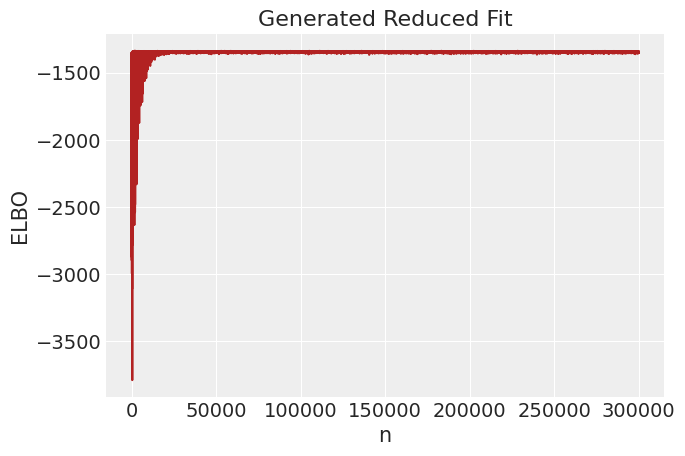

In [29]:
rand_elbo = pd.DataFrame(
    {'ELBO': -advi_fit_rand.hist,
     'n': np.arange(advi_fit_rand.hist.shape[0])})

ax43 = sns.lineplot(y='ELBO', x='n', data=rand_elbo, color="firebrick")
ax43.set_title('Generated Reduced Fit')